#  Прогнозирование заказов такси

Компания по услугам такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Для начала импортируем всевозможные пакеты, которые могут нам понадобиться

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import time 
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

Настало время импортировать данные и сммотреть на их качество, возможо иногда поправлять

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Никаких странных значений нету, аутлаеров тоже не выявлено, данные понятный, ровные, ничего выбивающегося. А значит время делать сэмплирование

Я сделаю семплирование в части анализа, так как мне кажется что это нелогично делать семплирование даже не смотря данные

## Анализ

Семплирование будем делать используя сумму заказов, так как нам важно именно общее количетсво заказов за час, и предсказывать нужно именно количество заказов на следующий час поэтому берем сумму, среднее количество нам не важно.

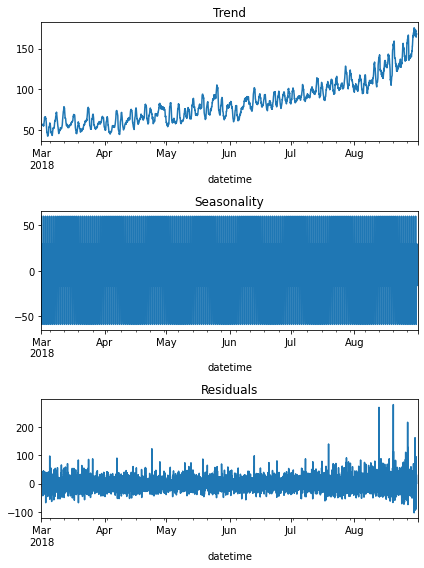

In [6]:
data = data.resample('1H').sum()

decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')

plt.tight_layout()

По итогам этих 3 графиков можно очень явно отследить сезонность данного действа, у остатков непонятное взаимодействие, единственное что можно сказать - к концу их становится больше, что касается тренда то он исключительно восходящий

Данные у нас имеются за 5 месяцев, построим график

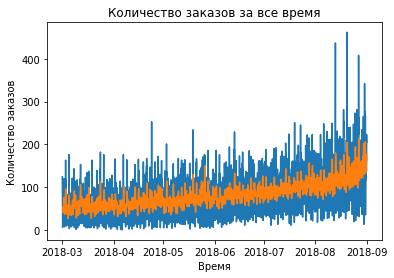

In [7]:
data['rolling_mean'] = data.rolling(10).mean()
plt.plot(data) 
plt.xlabel('Время') 
plt.ylabel('Количество заказов') 
  
# displaying the title
plt.title("Количество заказов за все время")
  
plt.show() 

У нас имеются явные периодические скачки, также ближе к сентябрю среднее количество заказов стремительно повышается

Когда стало ясно, что у нас имеются отчетвливые сезонные колебания можно переходить к обучению модели

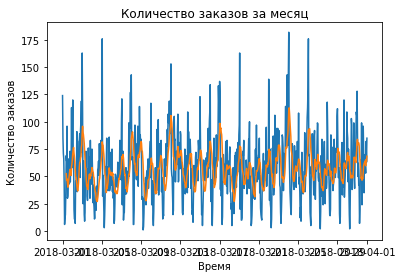

In [8]:
data1 = data['2018-03-01 00:00:00':'2018-04-01 00:00:00']
plt.plot(data1) 
plt.xlabel('Время') 
plt.ylabel('Количество заказов') 
plt.title("Количество заказов за месяц")
plt.show() 

Нужно еще больше сузить график, скорее всего колебания дневные либо недельные

1 марта 2018 - это четверг, но я хочу посмотреть именно недельные колебания, поэтому возьмем семь дней начиная с 12 по 18, так как это не праздничная неделя в отличии от предидущей

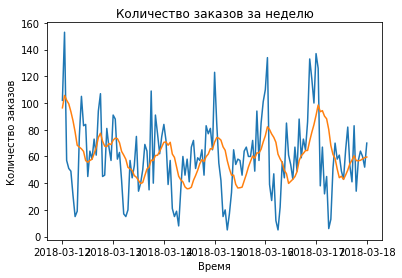

In [9]:
data1 = data['2018-03-12 00:00:00':'2018-03-18 00:00:00']
plt.plot(data1) 
plt.xlabel('Время') 
plt.ylabel('Количество заказов') 
plt.title("Количество заказов за неделю")
plt.show() 

Тут уже стало чуть более понятно, вот некоторые выводы:
1. отчетливо видно что самая большая часть заказов прилетает именно вечером
2. ночью с воскресенья на понедельник - больше всего заказов
3. с начала и до конца недели видна тенденция увеличения заказов вечером и уменьшения заказов утром
4. суббота - самый стабильный день, весь день достаточно среднее количество заказов

Можно попроовать декомпонировать данные, может быть будут еще какие то наблюдения

## Обучение

Для начала создадим признаки и функцию для их создания

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(data, 168, 24)

Написал именно 168, так как у нас в неделе 7 дней в каждой по 24 часа

Теперь создадим и обучим модель

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

In [13]:
grid = {
    'n_estimators': [50,100,150],
    'max_depth': [4,8,12]
}
model_rf = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits = 3)
rf_grid = GridSearchCV(model_rf,  param_grid=grid,  scoring='neg_root_mean_squared_error', cv=tscv)

rf_grid.fit(train_features, train_target)

best_score = rf_grid.best_score_ * -1
best_params = rf_grid.best_params_

print(best_score)
print(best_params)

23.62120836970698
{'max_depth': 12, 'n_estimators': 150}


Какой же я невнимательный

rmse равно 23.6, вообще достаточно неплохой результат, но мне кажется можно сделать лучше, попорубем библиотеку кэтбуст

In [15]:
grid = {
    'iterations': [50,100],
    'depth': [6,12]
}
model_cat = CatBoostRegressor(random_state=12345, verbose = 25)
tscv = TimeSeriesSplit(n_splits = 3)
model_cat = GridSearchCV(model_cat,  param_grid=grid,  scoring='neg_root_mean_squared_error', cv=tscv)

model_cat.fit(train_features, train_target)

best_score = model_cat.best_score_ * -1
best_params = model_cat.best_params_
print(best_score)
print(best_params)

Learning rate set to 0.464102
0:	learn: 24.0177712	total: 79.9ms	remaining: 3.92s
25:	learn: 9.9639708	total: 615ms	remaining: 567ms
49:	learn: 5.5950559	total: 1.11s	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.1898963	total: 43.2ms	remaining: 2.11s
25:	learn: 13.1598177	total: 769ms	remaining: 710ms
49:	learn: 8.9225681	total: 1.4s	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.2535915	total: 48.1ms	remaining: 2.36s
25:	learn: 15.1307312	total: 808ms	remaining: 746ms
49:	learn: 11.4226057	total: 1.51s	remaining: 0us
Learning rate set to 0.264166
0:	learn: 26.1896665	total: 40.7ms	remaining: 4.03s
25:	learn: 12.8157804	total: 646ms	remaining: 1.84s
50:	learn: 9.3499843	total: 1.23s	remaining: 1.18s
75:	learn: 6.3917841	total: 1.76s	remaining: 555ms
99:	learn: 4.6648449	total: 2.28s	remaining: 0us
Learning rate set to 0.294691
0:	learn: 28.6797414	total: 41.4ms	remaining: 4.09s
25:	learn: 15.0128472	total: 746ms	remaining: 2.12s
50:	learn: 12.2607484	total: 1.45s	remainin

У градинтного бустинга результат получился получше, результат равен 21, возьмем его как лучшую модель

## Тестирование

In [16]:
predictions_test = model_cat.best_estimator_.predict(test_features)
print(mean_squared_error(test_target, predictions_test, squared=False))

39.37987042383186


Получилось 39, неплохой результат, модель обучилась отлично!

По итогам работы было сделано следующее:
1. Обработаны и проанализированы данные
2. Была отчетливо проанализирована сезонность
3. Построена модель линейной регрессии
4. Построена модель градиентного бустнга на базе библиотеки catboost